# Airbnb Exploratory Data Analysis

This file contains the EDA done on the Airbnb data set after cleaning. 

Insights from this file are also used to drive decision making.

In [1]:
# These configurations expand the Jupyter notebook 
# They also control how much output can be displayed for each cell
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 30)
pd.set_option('display.max_colwidth', 20)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary python packages
from os import listdir
from os.path import join as pjoin
import pandas as pd
from time import time, sleep
import dateutil.parser
import re

import seaborn as sns
sns.set(style='whitegrid')

# Import utilities
from Utils.DataUtils import *
from Utils.UtilsViz import *
from Utils.UtilsGeoViz import *

In [3]:
# Some helper variables and functions
US_coord = [37.0902, -102]
NY_COORD = [40.7128, -74.0060]

In [14]:
listings = pd.read_csv('listings_cleaned.csv')
display(listings.head())

,id,host_since,host_location,host_response_time,host_response_rate,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,2008-09-07,"New York, New Yo...",within an hour,100.0,...,6,0,5,1,0.21
1,2595,2008-09-09,"New York, New Yo...",within a few hours,87.0,...,2,1,0,1,0.38
2,3647,2008-11-25,"New York, New Yo...",within a day,100.0,...,1,0,1,0,0.72
3,3831,2008-12-07,"New York, New Yo...",within a few hours,93.0,...,1,1,0,0,4.64
4,5022,2009-01-29,"Miami, Florida, ...",XX,100.0,...,1,1,0,0,0.10


Considering our clients are only interested in **2 Bedroom** apartments, let's filter out all the rows that have 2 Bedrooms

In [15]:
q = "bedrooms==2"
listings = listings.query(q)

# Remove additional columns that have only one field
drop_c = []
for c in listings.columns:
    if len(listings[c].unique())<2:
        drop_c.append(c)
        
for c in drop_c:
    if c in listings.columns:
        listings.drop(c, axis=1, inplace=True)

print("Number of Airbnb listings available :", listings.shape[0])

Number of Airbnb listings available : 6447


## Price data

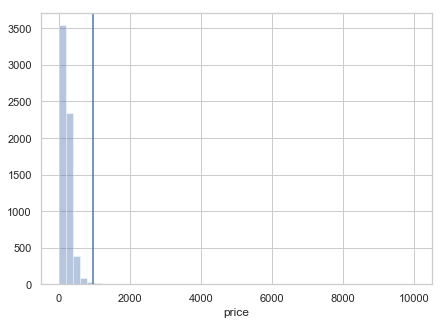

In [16]:
f,ax = plt.subplots(1,1,figsize=(7,5))
g = sns.distplot(listings["price"], ax=ax, kde=False)
g = g.axvline(np.percentile(listings["price"].values, 99))

There is a strong skew in the price information.

Let's visualize the graph again taking only data from **1-99** percentile.

This will also help us in avoiding skew/outliers during analysis, and present a more realistic picture.

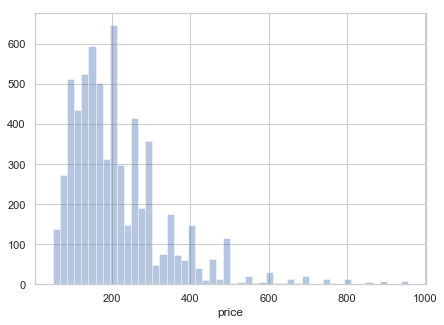

In [17]:
price_1p = np.percentile(listings["price"].values, 1)
price_99p = np.percentile(listings["price"].values, 99)
q = "(price>="+str(price_1p)+")" + "&" + "(price<="+str(price_99p)+")" 

listings = listings.query(q)

f,ax = plt.subplots(1,1,figsize=(7,5))
g = sns.distplot(listings["price"], ax=ax, kde=False)

## Additional expenses

**Security Deposits** and **Cleaning fee** are additional and optional expenses for every listing. 

Let's visualize their distributions to see their behaviour.

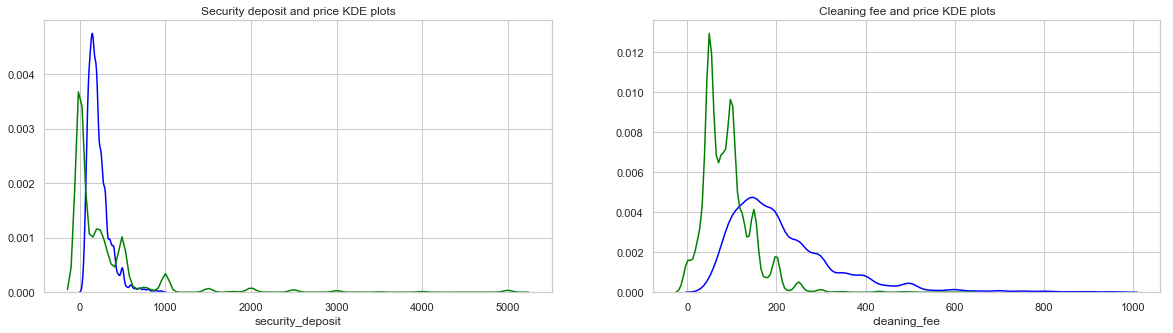

In [18]:
f, ax = plt.subplots(1, 2, figsize=(20, 5))

# Visualise the security deposit and price distributions together
g = sns.distplot(listings["price"], ax=ax[0], hist=False, kde=True, color="blue")
g = sns.distplot(listings["security_deposit"], ax=ax[0], hist=False, kde=True, color="green")
t = g.set(title="Security deposit and price KDE plots")

# Visualise the cleaning fees and price distributions together
g = sns.distplot(listings["price"], ax=ax[1], hist=False, kde=True, color="blue")
g = sns.distplot(listings["cleaning_fee"], ax=ax[1], hist=False, kde=True, color="green")
t = g.set(title="Cleaning fee and price KDE plots")

In [19]:
print("Correlation between price and security deposit :", np.round(np.corrcoef(listings["price"].values, listings["security_deposit"].values)[0,1], 2))
print("Correlation between price and security deposit :", np.round(np.corrcoef(listings["price"].values, listings["cleaning_fee"].values)[0,1], 2))

Correlation between price and security deposit : 0.13
Correlation between price and security deposit : 0.32


There are only weak correlations between Price with Security Deposit and Cleaning fee.

But it may be interesting to see how the additional expenses are charged across other factors such as type of **property**.

## Amenities

We will maintain a count of all the amenities provided to see how the number affects a listing pricing.

In [20]:
listings["num_amenities"] = listings["amenities"].apply(lambda v: len(v[1:-1].split(",")) if len(v) > 2 else 0)

Bin the amenities into groups for better visualisation

In [21]:
bins = list(range(0,90, 10))
listings['amenities_binned'] = pd.cut(listings['num_amenities'], bins)

Text(0.5, 0, 'Number of amenities')

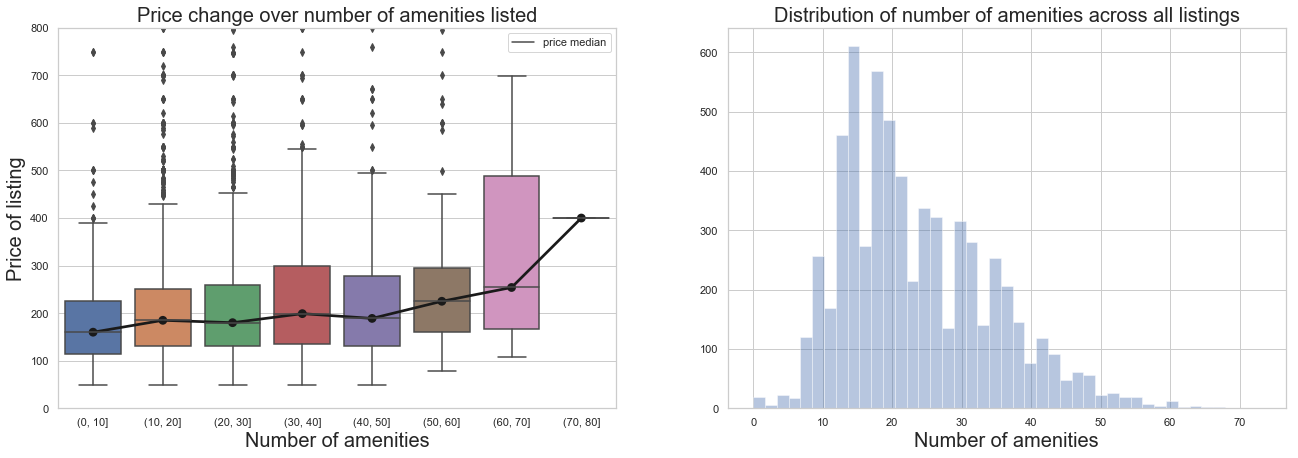

In [26]:
f, ax = plt.subplots(1,2,figsize=(22, 7))
g = plot_box(x="amenities_binned", y="price", data=listings, ax=ax[0], agg_rule="median",
            title="Price change over number of amenities listed",
            xlabel="Number of amenities", ylabel="Price of listing", ylim=800)
g.set_title("Price change over number of amenities listed",fontsize=20)
g.set_xlabel("Number of amenities",fontsize=20)
g.set_ylabel("Price of listing",fontsize=20)
g = sns.distplot(listings["num_amenities"], ax=ax[1], kde=False)
g.set_title("Distribution of number of amenities across all listings",fontsize=20)
g.set_xlabel("Number of amenities",fontsize=20)

## Accommodates

**Properties are homogenous in nature. (assumption provided with problem statement)**

While area is not an available column, the number of people who can be accommodated can be used as a proxy.

Therefore, properties that can accommdate more people, should potentially generate larger revenue.

Let's make a variable that contains the total number of people who can be accommodated, including guests.

In [28]:
listings["total_people"] = listings["guests_included"] + listings["accommodates"]

Group the total number of people who can be accommodated into categories for better visualization.

We can see how these categories behave with pricing of a listing.

Text(0.5, 0, 'Number of people who can be accommodated')

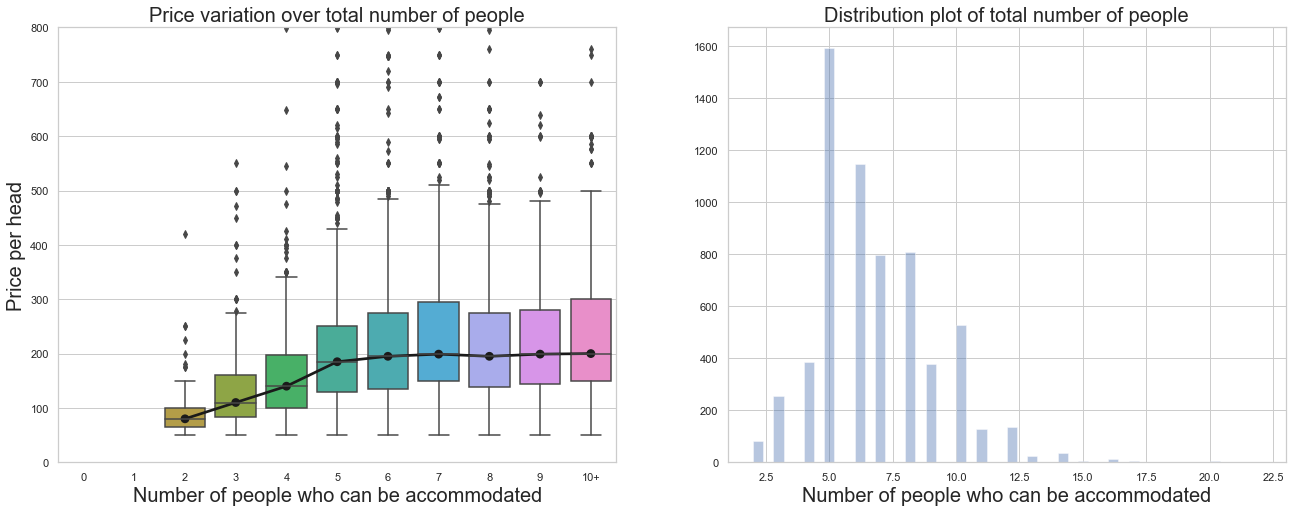

In [35]:
def group_accommodates(row):
    if row < 10:
        return str(int(row))
    elif row >= 10:
        return "10+"
    else:
        return row
    
listings["acc_group"] = listings["total_people"].apply(group_accommodates)
listings['acc_group'] = pd.Categorical(
    listings['acc_group'], 
    categories=['0','1','2','3','4','5','6', '7', '8', '9', '10+'], 
    ordered=True
)
listings.sort_values(by="acc_group", inplace=True)
agg_data = listings[["price", "acc_group"]].groupby(by=["acc_group"], as_index=False).median()

f, ax = plt.subplots(1,2,figsize=(22, 8))
g = sns.boxplot(x="acc_group", y="price", data=listings, ax=ax[0])
g = sns.pointplot(x="acc_group", y="price", data=agg_data, ax=ax[0], color="k")
g.set(ylim=[0,800])
# t = g.set(title=, xlabel=, ylabel=)

g.set_title("Price variation over total number of people",fontsize=20)
g.set_xlabel("Number of people who can be accommodated",fontsize=20)
g.set_ylabel("Price per head",fontsize=20)

g = sns.distplot(listings["total_people"], ax=ax[1], kde=False)
g.set_title("Distribution plot of total number of people", fontsize=20)
g.set_xlabel("Number of people who can be accommodated",fontsize=20)

Once the number of people who can be accommodated reaches numbers greater than 6, **the price charged per person seems to stabilize**.

## Neighbourhood groups

Neighbourhood groups can play a key role in pricing listings.

This column helps in understanding which areas can generate more revenue than others.

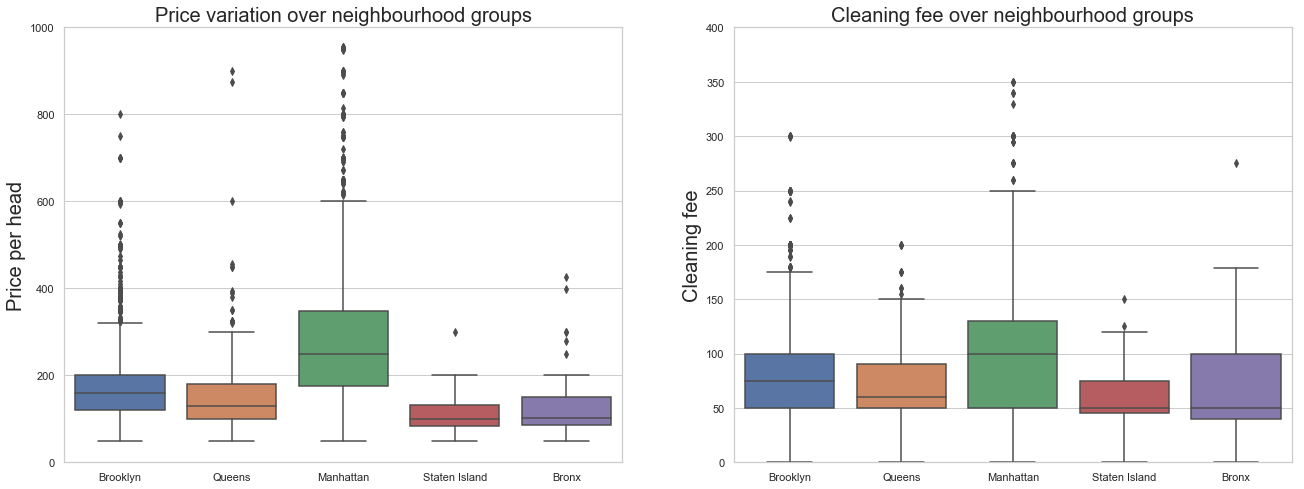

In [40]:
f, ax = plt.subplots(1,2,figsize=(22, 8))
g = sns.boxplot(x="neighbourhood_group_cleansed", y="price", data=listings, ax=ax[0])
g.set_title("Price variation over neighbourhood groups",fontsize=20)
g.set_xlabel("")
g.set_ylabel("Price per head",fontsize=20)
g.set_ylim([0, 1000])

# g = sns.boxplot(x="neighbourhood_group_cleansed", y="security_deposit", data=listings, ax=ax[1])
# t = g.set_ylim([0, 1500])
# # t = g.tick_params(labelsize=20)
# g.set_title("Security deposit over neighbourhood groups",fontsize=20)
# g.set_xlabel("")
# g.set_ylabel("Security deposit",fontsize=20)

g = sns.boxplot(x="neighbourhood_group_cleansed", y="cleaning_fee", data=listings, ax=ax[1])
# t = g.tick_params(labelsize=20)
g.set_title("Cleaning fee over neighbourhood groups",fontsize=20)
g.set_xlabel("")
g.set_ylabel("Cleaning fee",fontsize=20)
t = g.set_ylim([0, 400])

**Manhattan** neighbourhoods clearly stand out in terms of pricing, security deposit as wll as Cleaning/maintainence fees.

##  Property type

The Property types may also have an influence on pricing and additional expenses

Aggregate the less frequent property types into an 'Other' category.

In [41]:
apartment_list = ["Apartment", "House", "Townhouse", "Loft", "Condominium", "Serviced apartment"]
def populate_property_agg(v):
    if v not in apartment_list:
        return 'Other'
    return v

listings['property_agg'] = listings["property_type"].apply(populate_property_agg)
listings['property_agg'].value_counts()

Apartment             4957
House                  390
Condominium            327
Loft                   234
Townhouse              233
Other                  110
Serviced apartment      75
Name: property_agg, dtype: int64

Visualize the behaviour of pricing across different property types.

(0, 400)

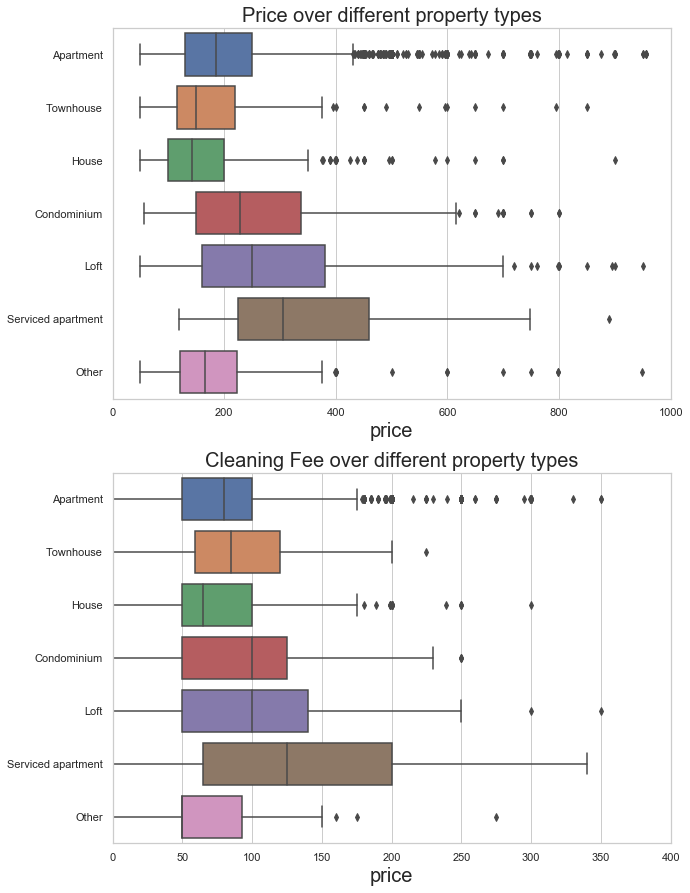

In [49]:
f, ax = plt.subplots(2,1,figsize=(10, 15))
g = sns.boxplot(y="property_agg", x="price", data=listings, ax=ax[0])
g.set_title("Price over different property types",fontsize=20)
g.set_xlabel("price",fontsize=20)
g.set_ylabel("")
g.set_xlim([0, 1000])

# g = sns.boxplot(y="property_agg", x="security_deposit", data=listings, ax=ax[1])
# t = g.set(title="Security Deposit over different property types", xlabel="price", ylabel="")

g = sns.boxplot(y="property_agg", x="cleaning_fee", data=listings, ax=ax[1])
g.set_title("Cleaning Fee over different property types",fontsize=20)
g.set_xlabel("price",fontsize=20)
g.set_ylabel("")
g.set_xlim([0, 400])


What kind of property types accommodate the most people?

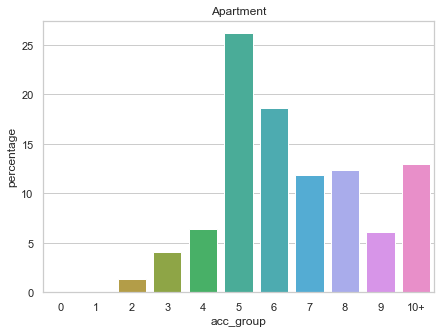

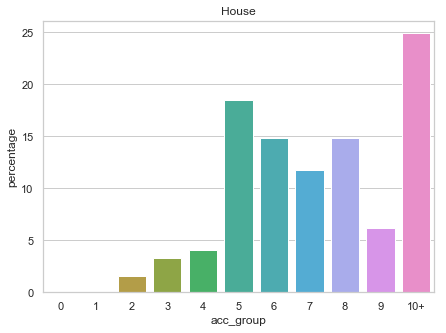

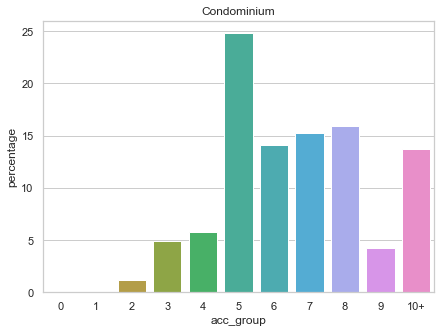

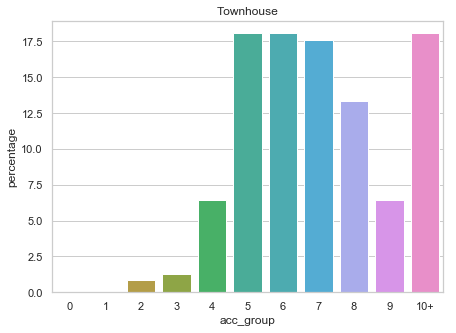

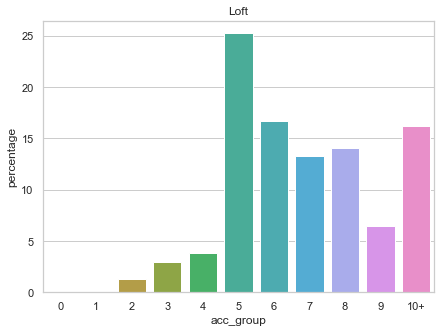

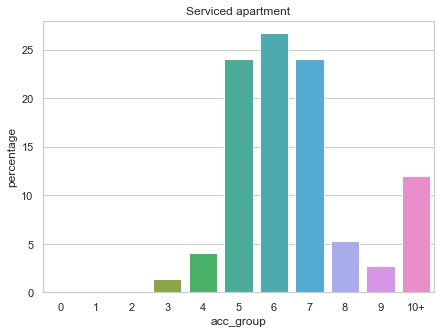

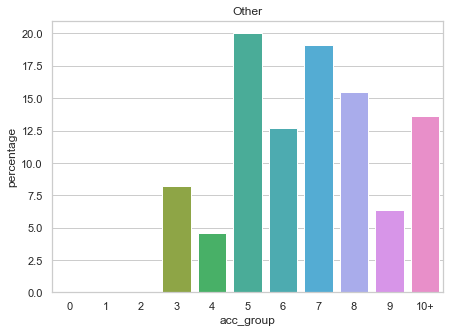

In [18]:
cols = ["property_agg", "acc_group"]
for pt in listings["property_agg"].unique():
    q = "property_agg==\""+pt+"\""
    pt_acc_vcs = listings.query(q)["acc_group"].value_counts().to_frame()
    pt_acc_vcs["acc_group_pct"] = np.round(100*(pt_acc_vcs["acc_group"] / pt_acc_vcs["acc_group"].sum()), 2)
    pt_acc_vcs.reset_index(drop=False, inplace=True)
    pt_acc_vcs.columns = ["acc_group", "count", "percentage"]
    f, ax = plt.subplots(1,1,figsize=(7,5))
    g = sns.barplot(x="acc_group",y="percentage", data=pt_acc_vcs, ax=ax).set(title=pt)

While apartments are numerous, *Houses, Townhouses, Serviced apartments* and are capable of housing a larger population.

## Minimum night stays

Do different property types typically have different minimum night stays implied?

In [19]:
listings[["property_agg", "minimum_nights"]].groupby(by="property_agg").median()

,minimum_nights
property_agg,
Apartment,3
Condominium,3
House,2
Loft,3
Other,2
Serviced apartment,30
Townhouse,3


*Serviced Apartments* seem to be the outlier in this dataset stating minimum nights as 30 days.

It may be useful to assume that the minimum number of nights for a property type can be kept as **3**.

### Room type

Does the type of room in a listing also affect pricing and additional expenses?

In [20]:
listings["room_type"].value_counts()

Entire home/apt    5808
Private room        518
Name: room_type, dtype: int64

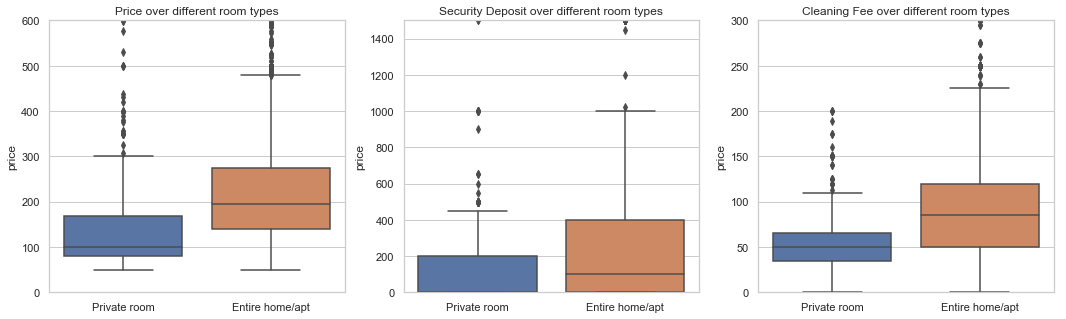

In [21]:
f, ax = plt.subplots(1,3,figsize=(18, 5))
g = sns.boxplot(x="room_type", y="price", data=listings, ax=ax[0])
t = g.set(title="Price over different room types", ylim=[0,600], ylabel="price", xlabel="")

g = sns.boxplot(x="room_type", y="security_deposit", data=listings, ax=ax[1])
t = g.set(title="Security Deposit over different room types", ylim=[0,1500], ylabel="price", xlabel="")

g = sns.boxplot(x="room_type", y="cleaning_fee", data=listings, ax=ax[2])
t = g.set(title="Cleaning Fee over different room types", ylim=[0,300], ylabel="price", xlabel="")

As expected, Entire homes or apartments charge a larger price than those that offer just a private room.

## Extra people

Do most listings charge for extra people? 

In [22]:
ep_vcs = listings["extra_people"].value_counts().to_frame().reset_index(drop=False)
ep_vcs.columns = ["Charge", "number of listings"]
print("Most occuring charges for extra people :")
display(ep_vcs.iloc[:5])

Most occuring charges for extra people :


,Charge,number of listings
0,0.0,3087
1,25.0,675
2,50.0,506
3,20.0,471
4,10.0,273


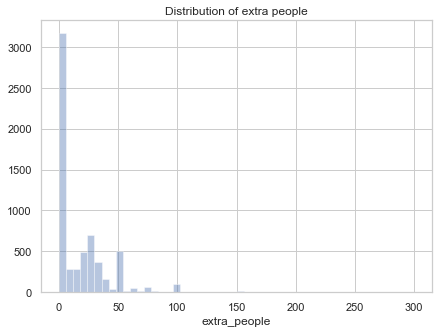

In [23]:
f, ax = plt.subplots(1,1,figsize=(7,5))
g = sns.distplot(listings["extra_people"], ax=ax, kde=False).set(title="Distribution of extra people")

Majority of listings do not seem to charge for extra people.

However this is still a potentially important revenue source.

## Booking and cancellations

How does the presence of *instant booking* features affect price?

In [24]:
listings["instant_bookable"].value_counts()

f    3970
t    2356
Name: instant_bookable, dtype: int64

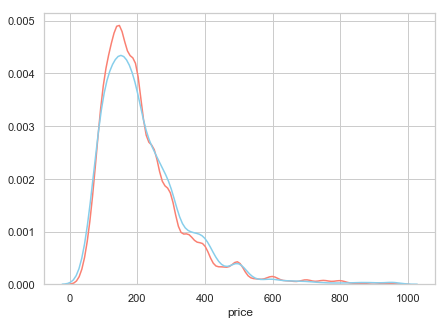

In [25]:
f, ax = plt.subplots(1,1,figsize=(7,5))
qt = "instant_bookable==\"t\""
qf = "instant_bookable==\"f\""
g = sns.distplot(listings.query(qf)["price"], ax=ax, kde=True, hist=False, color="salmon")
g = sns.distplot(listings.query(qt)["price"], ax=ax, kde=True, hist=False, color="skyblue")

It does not seem to have any significant effect on price.

Does the **cancellation policy** have different effects on price of a listing?

In [26]:
listings["cancellation_policy"].value_counts()

strict_14_with_grace_period    3344
flexible                       1505
moderate                       1450
super_strict_60                  24
super_strict_30                   3
Name: cancellation_policy, dtype: int64

Let's combine the *strict* policies into one category.

In [27]:
listings["cancellation_agg"] = listings["cancellation_policy"].apply(lambda x: x if "strict" not in x else "strict")
listings["cancellation_agg"].value_counts()

strict      3371
flexible    1505
moderate    1450
Name: cancellation_agg, dtype: int64

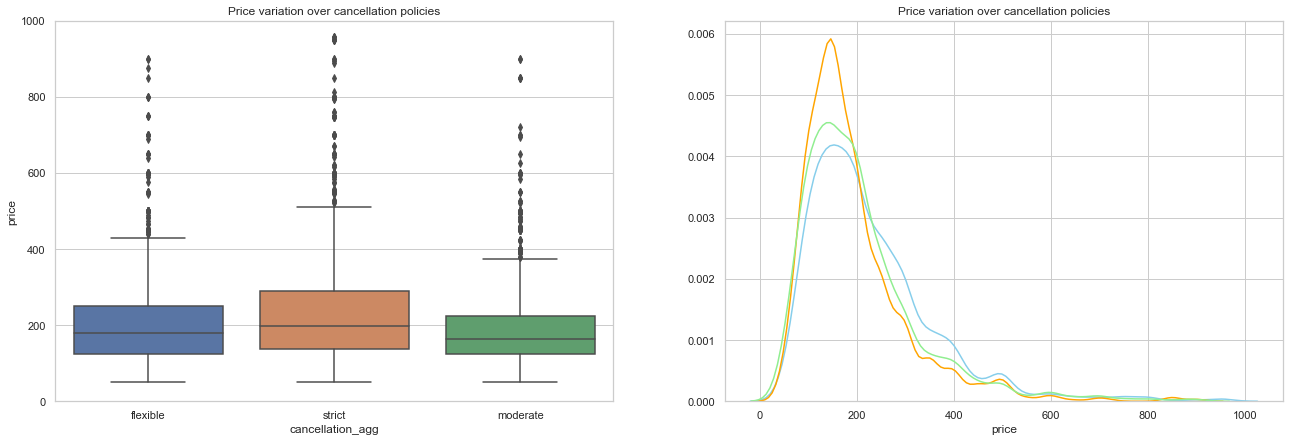

In [28]:
f, ax = plt.subplots(1,2,figsize=(22,7))
g = sns.boxplot(y="price", x="cancellation_agg", data=listings, ax=ax[0]).set(title="Price variation over cancellation policies", ylim=[0,1000])

qs = "cancellation_agg==\"strict\""
qf = "cancellation_agg==\"flexible\""
qm = "cancellation_agg==\"moderate\""
g = sns.distplot(listings.query(qs)["price"], ax=ax[1], kde=True, hist=False, color="skyblue")
g = sns.distplot(listings.query(qm)["price"], ax=ax[1], kde=True, hist=False,  color="orange")
g = sns.distplot(listings.query(qf)["price"], ax=ax[1], kde=True, hist=False, color="lightgreen")
t = g.set(title="Price variation over cancellation policies")

While the *moderate* cancellation policy tends to favor lower priced listings more than higher priced ones, cancellation policies do not seem to have any significant effect on the price.

------------

# GeoSpatial analysis

Looking at things for a neighborhood level might help us understand the *popular* areas as well as the *expensive* ones.

## Number of listings

Where are the most number of listings?

In [32]:
nbhood_listings_data = listings[["id", "neighbourhood_cleansed"]].groupby(by="neighbourhood_cleansed", as_index=False).count()
neighbourhoods_geojson_path = "neighbourhoods.geojson"
    
th_scale = [0,100,200,300,400,500,600]
m1 = folium.Map(location=NY_COORD, tiles='OpenStreetMap', zoom_start=11)
# Add a choropleth map
m1 = add_choroplethmap(m1=m1, data=nbhood_listings_data,
                       json_path=neighbourhoods_geojson_path, 
                       json_key='feature.properties.neighbourhood', 
                       threshold_scale=th_scale,
                       name="Neighbourhoods with listings")


open_map_in_browser(m1, "geo_listings.html")
m1

##  Median price of neighborhoods

In [33]:
nbhood_price_data = listings[["price", "neighbourhood_cleansed"]].groupby(by="neighbourhood_cleansed", as_index=False).median() # agg(["mean", "median", "max", "min"])
neighbourhoods_geojson_path = "neighbourhoods.geojson"
    
th_scale = [0,100,200,300,400,500]

m1 = folium.Map(location=NY_COORD, tiles='OpenStreetMap', zoom_start=11)
# Add a choropleth map
m1 = add_choroplethmap(m1=m1, data=nbhood_price_data,
                       json_path=neighbourhoods_geojson_path, 
                       json_key='feature.properties.neighbourhood', 
                       threshold_scale=th_scale,
                       name="Neighbourhoods Median Price",
                       color='Greens')


open_map_in_browser(m1, "geo_price.html")
m1

## Observations:

- Neighbourhoods in Brooklyn has more listings than Manhattan
- Neighbourhoods in Manhattan are more expensive than Brooklyn
- Larger properties can accommodate more guests, and hence help achieve a faster ROI

It's interesting to note that there is a trade off clearly observable here.

While Manhattan generates more revenue for every listing, a majority of listings reside in Brooklyn.

A trade off in terms of cost to location may be considered when expanding in New york City.

In [31]:
# save the file to disk
listings.to_csv("./listings_2b_fe.csv", index=False)